# IBM Dynamical Decoupling Optimizations with Superstaq

<a target="_blank" href="https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder" align="left" style="margin-left: 10px;"/>
</a>

[Dynamical decoupling (DD)](https://arxiv.org/abs/quant-ph/9803057) is an error mitigation technique used to suppress noise added to computation from system-environment interaction (i.e. decoherence error). DD is implemented during algorithm execution by adding special gate sequences that are equal to the identity operation in periods of qubit idling. Examples of DD sequences include XX, XY4, XY8, and UDD, among others.

Below is a brief tutorial on Superstaq dynamical decoupling optimizations for the IBM family of superconducting quantum devices. In the example, a CPMG sequence, XX, will be used. 

Many [research articles](https://arxiv.org/abs/2207.03670) can be found that describe the variations and benefits of DD. For more information about IBM Quantum, visit their website [here](https://quantum-computing.ibm.com/).

Users have the ability to specify the dynamical decoupling strategy desired. The following dynamical decoupling strategies are supported: <br> 
<br>
**Dynamic (default)**: Spaces pulses in a sequence based on sequence length, oblivious to sequences placed on neighboring qubits. <br>
**Static_context_aware**: Spacing each sequence's gates so that DD executes at alternating intervals on neighboring qubits. <br>


## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

In [2]:
# Required Superstaq imports
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install -q qiskit-superstaq[examples]
    print("Installed qiskit-superstaq. Please restart the kernel to import the packages.")

# Optional imports
import os  # used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [7]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider(
    api_key="SUPERSTAQ_API_KEY",
)

This notebook will target IBM's seven-qubit Perth device.

In [8]:
backend = provider.get_backend("ibmq_perth_qpu")

To submit jobs to the IBM machine, we will use a `QiskitRuntimeService`. This will require `qiskit-ibm-runtime` and an accout on [IBM Quantum](https://quantum-computing.ibm.com/).

In [17]:
# Required Qiskit Runtime imports
try:
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit_ibm_runtime import Sampler, Session
except ImportError:
    print("Installing qiskit_ibm_runtime...")
    %pip install -q qiskit_ibm_runtime
    print("Installed qiskit_ibm_runtime. Please restart the kernel to import the packages.")


# Save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance="INSTANCE", token="IBM_QUANTUM_API_KEY">")

service = QiskitRuntimeService()
ibm_backend = service.backend("ibm_perth")

## Circuit Compilation and Optimization with Superstaq

We will start by creating a circuit using Qiskit. In this example, we will use the Bernstein Vazirani (BV) algorithm to find the secret string '1111.' The BV benchmark circuit has five qubits.

In [9]:
qc = qiskit.QuantumCircuit(5,4)
for i in range(4):
    qc.h(i)
qc.x(4)
qc.h(4)
for i in range(4):
    qc.cx(i, 4)
qc.barrier()
for i in range(5):
    qc.h(i)
for i in range(4):
    qc.measure(i,i)

qc.draw(fold=-1)

┌───┐                          ░ ┌───┐┌─┐         
q_0: ┤ H ├───────■──────────────────░─┤ H ├┤M├─────────
     ├───┤       │                  ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├───────┼────■─────────────░─┤ H ├─╫─┤M├──────
     ├───┤       │    │             ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├───────┼────┼────■────────░─┤ H ├─╫──╫─┤M├───
     ├───┤       │    │    │        ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├───────┼────┼────┼────■───░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ ├───┤ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤ H ├─╫──╫──╫──╫─
     └───┘└───┘└───┘└───┘└───┘└───┘ ░ └───┘ ║  ║  ║  ║ 
c: 4/═══════════════════════════════════════╩══╩══╩══╩═
                                            0  1  2  3

 Next, we will compile the circuit so that it's executable on IBM Perth.

In [11]:
qc_compiled = backend.compile(qc)
qc_compiled.circuit.draw(fold=-1)

┌──────────┐┌─────────┐ ┌─────────────┐┌─────────┐  ┌─────────┐  ┌─────────┐┌─┐                                                                                                                                                                                                 ░                                     
q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├─┤0            ├┤ Rz(π/2) ├──┤ Rx(π/2) ├──┤ Rz(π/2) ├┤M├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────────────
     ├─────────┬┘├─────────┴┐│  Acecr(π/2) │├─────────┤┌─┴─────────┴─┐├─────────┤└╥┘┌─────────────┐┌─────────┐                                                                                                                                                       ┌─────────────┐ ░ ┌─────────┐┌─────────┐┌─────────┐   
q_1: ┤ Rx(π/2) ├─┤ Rz(3π/2) ├┤1            ├┤ Rx(π/2) ├┤1            ├┤ Rx(π/2) ├─╫─┤1            ├┤ Rx(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1            ├─░─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├───
     ├─────────┴┐├─────────┬┘└─────────────┘└─────────┘│             │└─────────┘ ║ │  Acecr(π/2) │├─────────┤┌─────────┐┌─────────┐                ┌─┐                                                                                                              │             │ ░ └─────────┘└─────────┘└─────────┘   
q_2: ┤ Rz(3π/2) ├┤ Rx(π/2) ├───────────────────────────┤  Acecr(π/2) ├────────────╫─┤0            ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────────┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────┤  Acecr(π/2) ├─░─────────────────────────────────────
     ├──────────┤├─────────┤                           │             │┌─────────┐ ║ └─┬─────────┬─┘├─────────┤└───┬─┬───┘├─────────┤┌──────────────┐└╥┘┌─────────┐ ┌─────────┐┌───────┐┌─────────────┐┌──────────┐┌─────────┐┌───────┐┌─────────────┐┌─────────┐┌───┐│             │ ░ ┌─────────┐┌─────────┐┌─────────┐┌─┐
q_3: ┤ Rz(3π/2) ├┤ Rx(π/2) ├───────────────────────────┤0            ├┤ Rz(π/2) ├─╫───┤ Rx(π/2) ├──┤ Rz(π/2) ├────┤M├────┤ Rz(π/2) ├┤0             ├─╫─┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(π) ├┤0            ├┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(π) ├┤0            ├┤ Rz(π/2) ├┤ X ├┤0            ├─░─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤M├
     └──────────┘└─────────┘                           └─────────────┘└─────────┘ ║   └─────────┘  └─────────┘    └╥┘    └─────────┘│              │ ║ └─────────┘ └─────────┘└───────┘│             │└──────────┘└─────────┘└───────┘│             │└─────────┘└───┘└─────────────┘ ░ └─────────┘└─────────┘└─────────┘└╥┘
q_4: ─────────────────────────────────────────────────────────────────────────────╫────────────────────────────────╫────────────────┤  Acecr(-π/2) ├─╫─────────────────────────────────┤  Acecr(π/2) ├────────────────────────────────┤  Acecr(π/2) ├────────────────────────────────────────────────────────────────────╫─
     ┌─────────┐ ┌─────────┐   ┌─────────┐                                        ║                                ║                │              │ ║ ┌──────────┐┌─────────┐         │             │┌──────────┐                    │             │                                ░                                   ║ 
q_5: ┤ Rz(π/2) ├─┤ Rx(π/2) ├───┤ Rz(π/2) ├────────────────────────────────────────╫────────────────────────────────╫────────────────┤1             ├─╫─┤ Rz(3π/2) ├┤ Rx(π/2) ├─────────┤1            ├┤ Rz(3π/2) ├────────────────────┤1            ├────────────────────────────────░───────────────────────────────────╫─
     └─────────┘ └─────────┘   └─────────┘                                        ║                                ║                └──────────────┘ ║ └──────────┘└─────────┘         └─────────────┘└──────────┘   

Although we are used to looking at quantum circuits at the gate abstraction level, circuits that target the IBM machines must be transformed into pulse sequences so that they can be executed on the physical hardware. We will examine the pulse sequence in the cell below to get a better understanding how Superstaq optimizes a circuit. As a note, `pulse_sequences` are a useful tool that are only used for analysis in this notebook;  `qiskit-ibm-runtime` only accepts pulse gate circuits, which can be returned with `qc_compiled.pulse_gate_circuit`.

The circuit below represented as a pulse sequence is compiled using default Superstaq optimization.

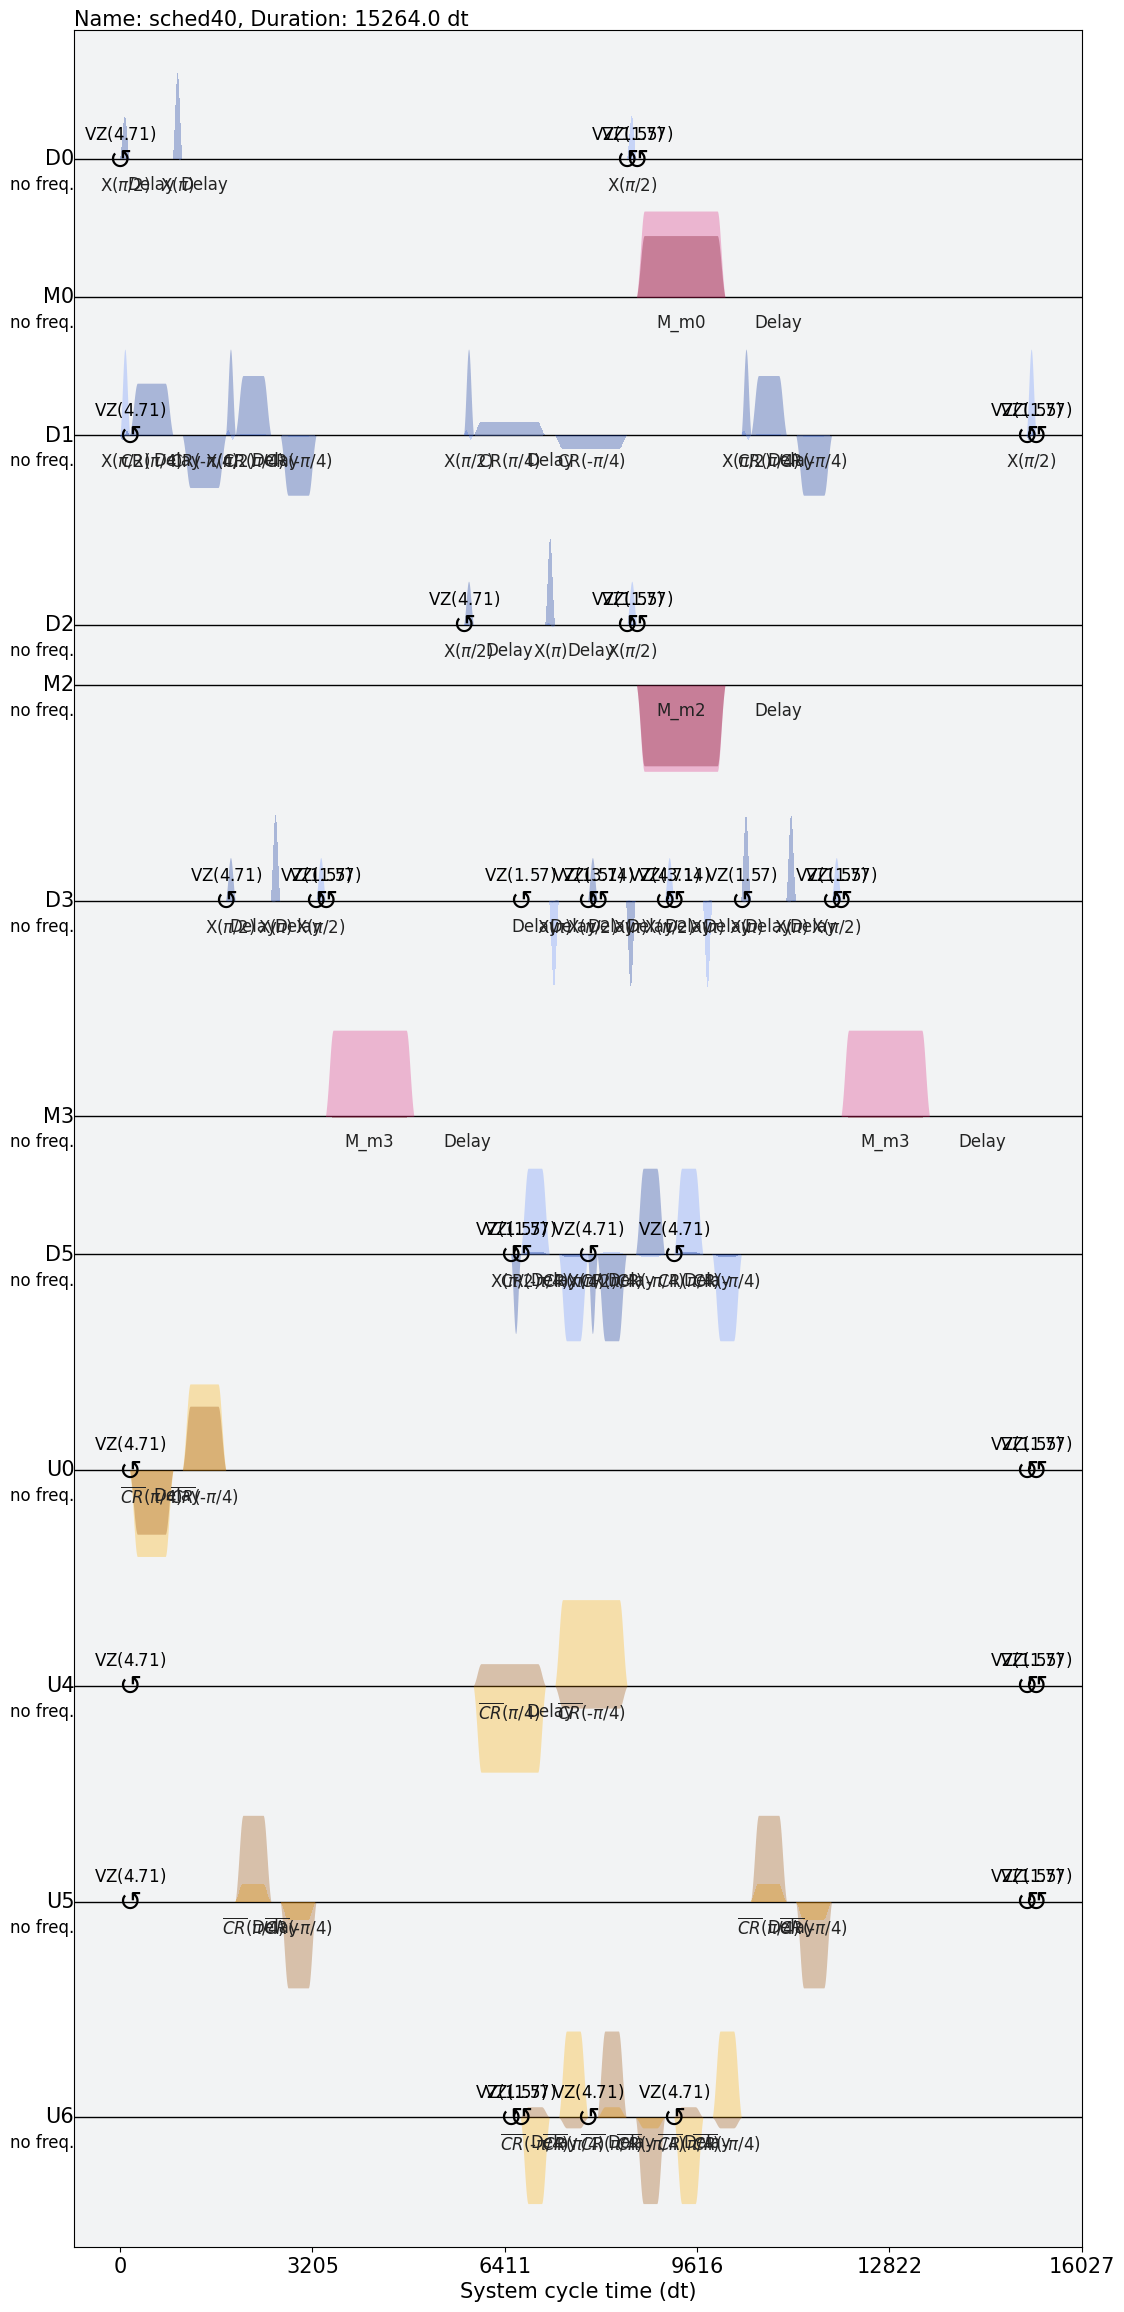

In [6]:
qc_compiled.pulse_sequence.draw()

## Dynamical Decoupling with Superstaq

Now we will compile the original circuit again, triggering DD insertion as an included optimization. The example below shows the dynamic strategy. Dynamic DD is default, but it can also be invoked using `dynamical_decoupling = True , dd_strategy = 'dynamic'`.

In the `pulse_sequence`, notice how each of the idle windows include two additional $X(\pi)$ gates, or one CPMG sequence.

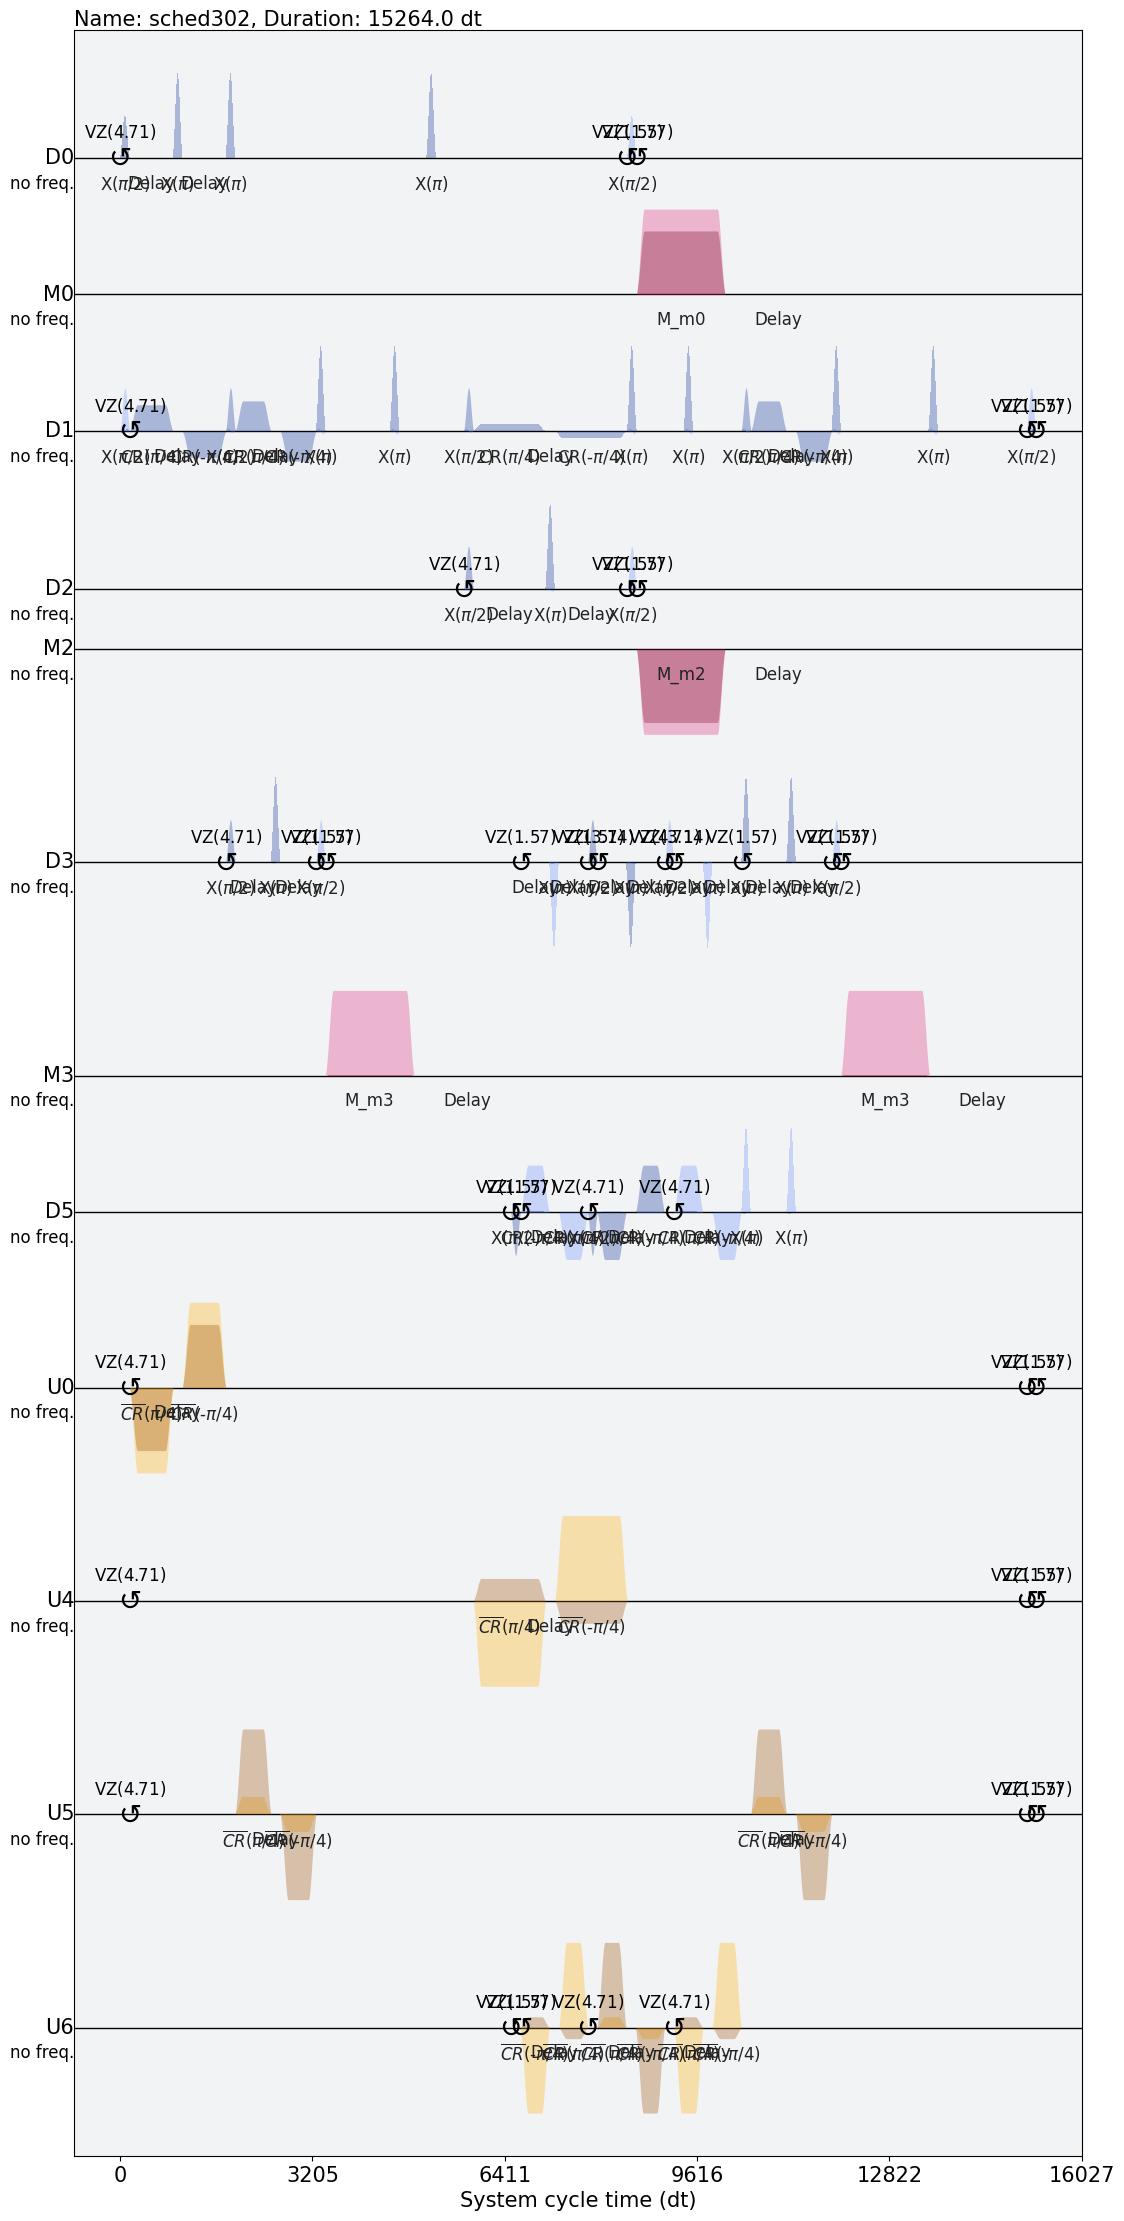

In [14]:
qc_compiled_dd_dynamic = backend.compile(qc, dynamical_decoupling=True, dd_strategy = 'dynamic')
qc_compiled_dd_dynamic.pulse_sequence.draw()

Finally, we will compile the original circuit once more so that DD insertion follows the `static_context_aware` strategy. Notice in the `pulse_sequence` how each qubit idle window has more than one CPMG sequence and that each $X(\pi)$ operation appear at specific time intervals. 

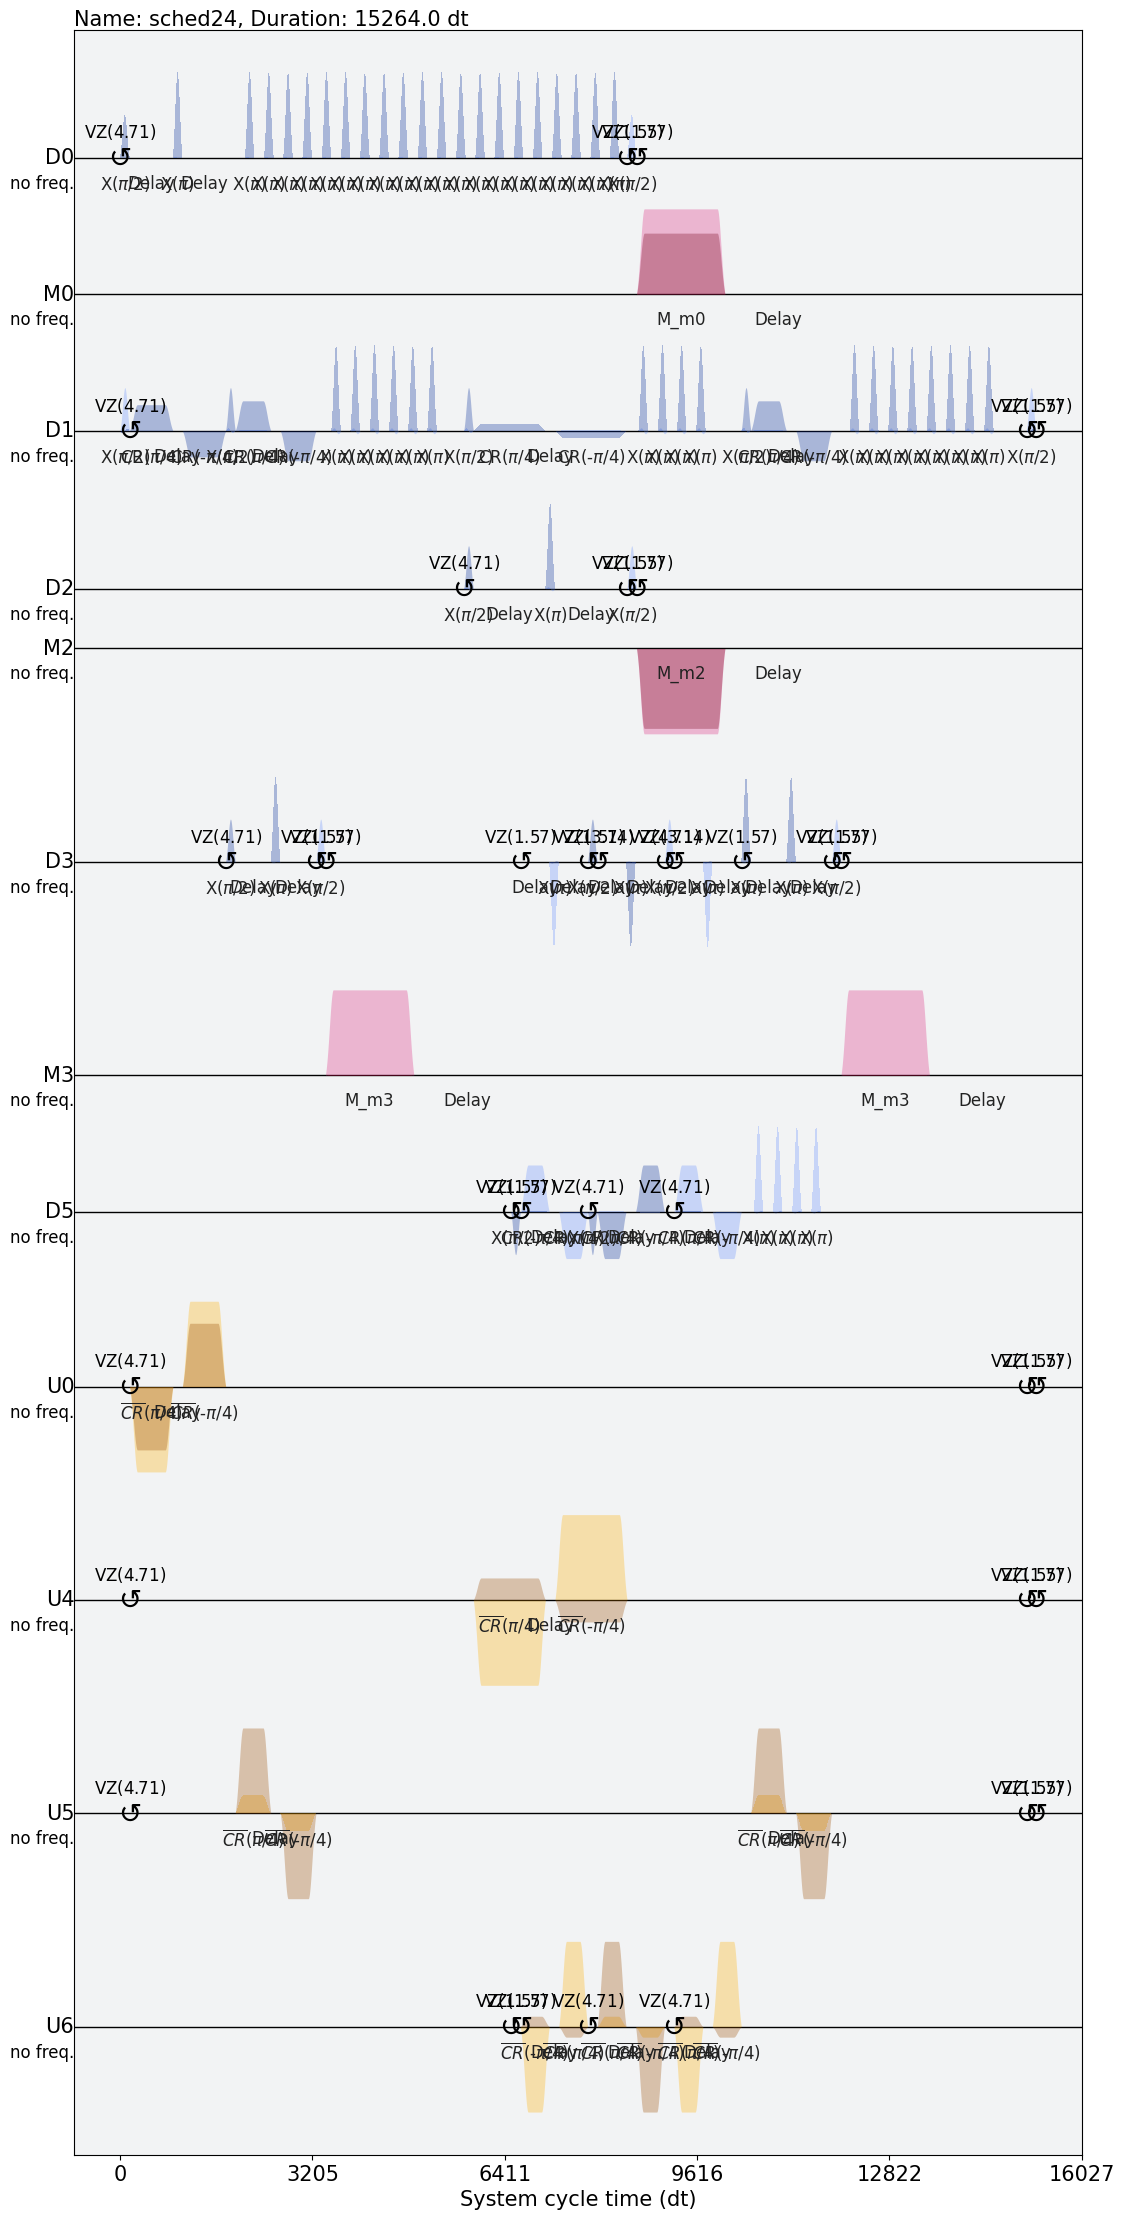

In [10]:
qc_compiled_dd_static_context_aware = backend.compile(qc, dynamical_decoupling=True, dd_strategy="static_context_aware")
qc_compiled_dd_static_context_aware.pulse_sequence.draw()

## Real QC Machine Evaluation

In this section, we will see how the Superstaq-optimized BV with DD compares to qiskit's compilation and optimization. 

When we submit Superstaq compiled circuits, we will `skip_transpilation` to `True` so that `qiskit-ibm-runtime` does not recompile the Superstaq optimized `pulse_gate_circuit`.

In [ ]:
shots = 1000

with Session(service=service, backend=ibm_perth):
    sampler = Sampler()
    job_ss_dd = sampler.run(
        circuits=[qc_compiled_dd_static_context_aware.pulse_gate_circuit],  
        skip_transpilation=True, # skip qiskit transpilation
        shots=shots,
    )

We will also create a second session where we allow `qiskit-ibm-runtime` to compile and optimize the original BV circuit.

In [ ]:
with Session(service=service, backend=ibm_perth):
    sampler = Sampler()
    job_ibm = sampler.run(
        circuits=[qc],  
        skip_transpilation=False, # enable qiskit transpilation
        shots=shots,
    )

In [ ]:
ss_dd_results =  job_ss_dd.result().quasi_dists[0]

ibm_results = job_ibm.result().quasi_dists[0]

When we fetch the quasiprobability distributions, we see that Superstaq decreases the error by a third, bringing the probability of success to about 90\% on the five-qubit BV circuit.

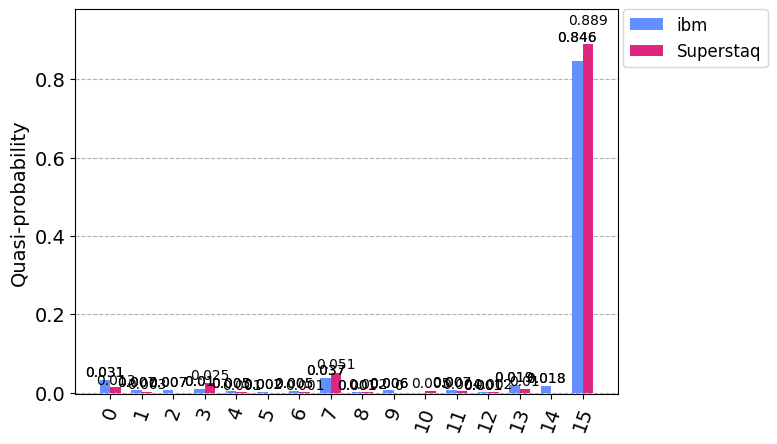

In [40]:
qiskit.visualization.plot_histogram([ibm_results,ss_dd_results],
                                    legend=['ibm','Superstaq'])